In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

def analisar_seguranca_por_uf(uf, caminho_dados, pop_minima=100000, ano_analise=2024):
    """
    Realiza análise de segurança pública para uma UF específica.
    
    Parâmetros:
    -----------
    uf : str
        Sigla da UF para análise (ex: 'RJ', 'SP', 'MG')
    caminho_dados : dict
        Dicionário com caminhos para os arquivos de dados
        Deve conter 'populacao' e 'df_unificado'
    pop_minima : int, opcional
        População mínima dos municípios a serem analisados (padrão: 100000)
    ano_analise : int, opcional
        Ano a ser analisado (padrão: 2024)
    """
    # Carregar dados de população
    df_populacao = pd.read_excel(caminho_dados['populacao'], sheet_name='MUNICÍPIOS', 
                               skiprows=1, skipfooter=1)
    df_populacao['NOME DO MUNICÍPIO'] = df_populacao['NOME DO MUNICÍPIO'].str.lower()
    df_populacao['chave'] = df_populacao['UF'] + df_populacao['NOME DO MUNICÍPIO']
    
    # Carregar dados de ocorrências
    df = pd.read_parquet(caminho_dados['df_unificado'])

    # Carregar dados de óbitos DataSUS
    df_obitos_arma_fogo = pd.read_csv(caminho_dados['df_obitos_arma_fogo'])
    
    # Formatação de municípios
    df['municipio'] = df['municipio'].apply(formatar_municipio)
    df['chave_uf'] = df['uf'] + df['municipio']
    
    # Filtrar por UF especificada
    df_uf = df[df['uf'] == uf].reset_index(drop=True)
    print(f"Analisando dados da UF: {uf}")
    print(f"Total de registros: {len(df_uf)}")
    
    # Remover municípios não informados
    df_uf_c_mun = df_uf[df_uf['municipio'] != 'NÃO INFORMADO'].reset_index(drop=True)
    print(f"Registros com município informado: {len(df_uf_c_mun)}")
    
    # Adicionar dados de população
    df_uf_c_mun['populacao'] = df_uf_c_mun['chave_uf'].map(df_populacao.set_index('chave')['POPULAÇÃO ESTIMADA'])

    # Adicionar dados de óbitos
    df_uf_c_mun['obitos'] = df_uf_c_mun['chave_uf'].map(df_obitos_arma_fogo.set_index('chave_uf')['obitos'])

    
    # Filtrar municípios por população mínima e ano de análise
    df_uf_mun_pop_min = df_uf_c_mun[(df_uf_c_mun['populacao'] > pop_minima) & 
                                  (df_uf_c_mun['ano'] == ano_analise)].reset_index(drop=True)
    print(f"Municípios com população > {pop_minima} habitantes: {df_uf_mun_pop_min['municipio'].nunique()}")
    
    # Calcular taxa por 100 mil habitantes
    df_uf_mun_pop_min['tx_100_mil_hab'] = df_uf_mun_pop_min['valor'] / df_uf_mun_pop_min['populacao'] * 100000
    df_uf_mun_pop_min['obitos_100_mil_hab'] = df_uf_mun_pop_min['obitos'] / df_uf_mun_pop_min['populacao'] * 100000

    
    # Resumo por categoria
    print("\nSumário por categoria de crime:")
    print(df_uf_c_mun.groupby('categoria')['valor','obitos'].sum().sort_values(ascending=False).head(10))
    
    # Analisar categorias específicas
    categorias_analise = [
        'Tentativa de homicídio',
        'Morte no trânsito ou em decorrência dele (exceto homicídio doloso)',
        'Crimes Contra a Vida'
    ]
    
    # Criar dicionário com dados por categoria
    vars_selecionadas = {}
    for categoria in categorias_analise:
        if categoria in df_uf_mun_pop_min['categoria'].unique():
            dados_cat = df_uf_mun_pop_min[df_uf_mun_pop_min['categoria'] == categoria]
            vars_selecionadas[categoria] = dados_cat.groupby('municipio')['tx_100_mil_hab','obitos_100_mil_hab'].sum().sort_values(ascending=True)
        else:
            print(f"Categoria '{categoria}' não encontrada nos dados da UF {uf}")
    
    # Verificar se temos dados suficientes para análise
    if len(vars_selecionadas) < 2:
        print(f"Dados insuficientes para análise da UF {uf}. Necessárias pelo menos 2 categorias.")
        return None
    
    # Criar DataFrame das variáveis selecionadas
    df_variaveis_selecionadas = pd.DataFrame(vars_selecionadas)
    
    # Mostrar tabela ordenada
    print("\nRanking de municípios por taxa de tentativa de homicídio:")
    print(df_variaveis_selecionadas.sort_values(by='Tentativa de homicídio', ascending=True))
    
    # Plot do gráfico de dispersão com quadrantes
    gerar_grafico_quadrantes(df_variaveis_selecionadas, uf)
    
    return df_variaveis_selecionadas.sort_values(by='Tentativa de homicídio', ascending=True)

def formatar_municipio(municipio):
    """Formata o nome do município."""
    if municipio == 'NÃO INFORMADO':
        return 'NÃO INFORMADO'
    elif pd.isna(municipio): #verifica se é nulo
        return 'NÃO INFORMADO' #trata nulos como 'Não informado'
    else:
        return municipio.lower()

def gerar_grafico_quadrantes(df_dados, uf):
    """Gera gráfico de dispersão com quadrantes para análise das categorias."""
    if 'Tentativa de homicídio' not in df_dados.columns or \
       'Morte no trânsito ou em decorrência dele (exceto homicídio doloso)' not in df_dados.columns:
        print("Dados insuficientes para gerar o gráfico")
        return
    
    plt.figure(figsize=(12, 8))
    
    # Definir eixos x e y
    eixo_x = 'Tentativa de homicídio'
    eixo_y = 'Morte no trânsito ou em decorrência dele (exceto homicídio doloso)'
    eixo_hue = 'Crimes Contra a Vida' if 'Crimes Contra a Vida' in df_dados.columns else None
    
    # Criar o scatterplot com Seaborn
    ax = sns.scatterplot(
        data=df_dados,
        x=eixo_x,
        y=eixo_y,
        hue=eixo_hue
    )
    
    # Calcular os valores medianos para definir os quadrantes
    media_x = df_dados[eixo_x].quantile(0.5)
    media_y = df_dados[eixo_y].quantile(0.5)
    
    # Desenhar as linhas dos quadrantes
    ax.axvline(media_x, color='gray', linestyle='--')
    ax.axhline(media_y, color='gray', linestyle='--')
    
    # Adicionar anotações com nomes dos municípios
    for idx, row in df_dados.iterrows():
        ax.annotate(
            idx,
            (row[eixo_x], row[eixo_y]),
            textcoords="offset points",
            xytext=(5, 5),
            ha='left'
        )
    
    plt.title(f'Crimes em Municípios de {uf} (Quadrantes)')
    plt.xlabel(eixo_x)
    plt.ylabel(eixo_y)
    if eixo_hue:
        plt.legend(title=eixo_hue)
    plt.tight_layout()
    plt.show()

# Exemplo de uso
if __name__ == "__main__":
    # Configurar caminhos dos arquivos
    base_dir = os.path.expanduser("~")  # Pasta home do usuário
    caminhos = {
        'populacao': os.path.join(base_dir, 'OneDrive', 'Projetos', 'Python', 'Segurança Pública', 
                                 'data', 'raw', 'estimativa_dou_2024.xls'),
        'df_unificado': os.path.join(base_dir, 'OneDrive', 'Projetos', 'Python', 'Segurança Pública', 
                                    'data', 'processed', 'df_unificado.parquet'),
        'df_obitos_arma_fogo': (r'C:\Users\daviw\OneDrive\Projetos\Python\Segurança Pública\data\processed\obitos_arma_fogo_2023_uf.csv') 
    }
    
    # Realizar análise para o RJ (exemplo)
    resultado_rj = analisar_seguranca_por_uf('RJ', caminhos)
    
    # Para analisar outra UF, basta chamar a função com a sigla desejada
    # Exemplo: resultado_sp = analisar_seguranca_por_uf('SP', caminhos)

Analisando dados da UF: RJ
Total de registros: 105196
Registros com município informado: 98532


KeyError: "None of ['chave_uf'] are in the columns"

Analisando dados da UF: SP
Total de registros: 698152
Registros com município informado: 691440
Municípios com população > 100000 habitantes: 80

Sumário por categoria de crime:
categoria
Ocorrências não violentas                                             737485.0
Tentativa de homicídio                                                 57784.0
Morte no trânsito ou em decorrência dele (exceto homicídio doloso)     48259.0
Crimes Contra a Vida                                                   34317.0
Mortes a esclarecer (sem indício de crime)                             33298.0
Name: valor, dtype: float64

Ranking de municípios por taxa de tentativa de homicídio:
                    Tentativa de homicídio  \
municipio                                    
valinhos                          2.285244   
são caetano do sul                2.324109   
são carlos                        3.015522   
catanduva                         3.356493   
salto                             3.568243   
...     

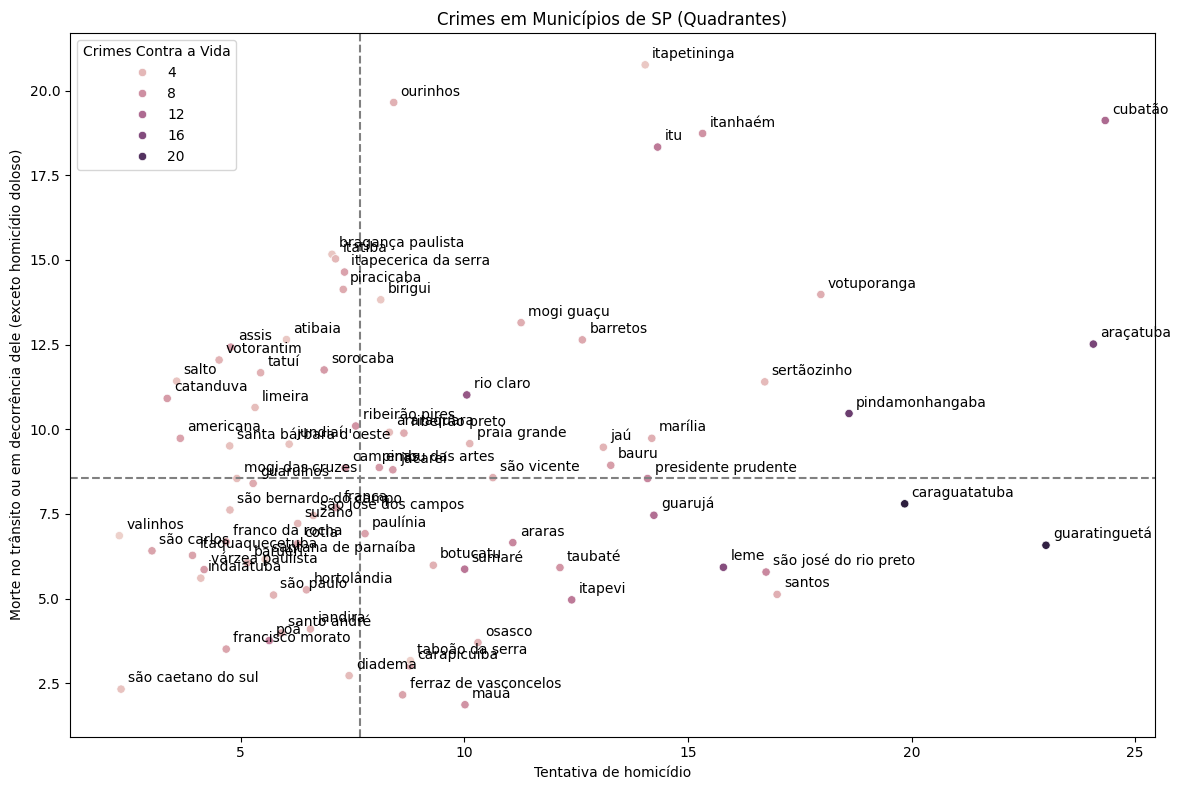

,Tentativa de homicídio,Morte no trânsito ou em decorrência dele (exceto homicídio doloso),Crimes Contra a Vida
municipio,,,
valinhos,2.285244,6.855733,1.523496
são caetano do sul,2.324109,2.324109,2.905136
são carlos,3.015522,6.407985,6.031045
catanduva,3.356493,10.908603,6.712986
salto,3.568243,11.418376,2.854594
...,...,...,...
pindamonhangaba,18.601731,10.463474,18.020427
caraguatatuba,19.846333,7.796774,23.390321
guaratinguetá,23.005505,6.573001,23.005505


In [5]:
analisar_seguranca_por_uf('SP',caminhos)

Analisando dados da UF: MG
Total de registros: 927960
Registros com município informado: 921240
Municípios com população > 100000 habitantes: 36

Sumário por categoria de crime:
categoria
Ocorrências não violentas                                             163003.0
Tentativa de homicídio                                                 42047.0
Crimes Contra a Vida                                                   33464.0
Morte no trânsito ou em decorrência dele (exceto homicídio doloso)     22540.0
Mortes a esclarecer (sem indício de crime)                                 0.0
Name: valor, dtype: float64

Ranking de municípios por taxa de tentativa de homicídio:
                      Tentativa de homicídio  \
municipio                                      
passos                              2.574444   
ituiutaba                           5.639257   
itaúna                              6.829268   
varginha                            7.002703   
poços de caldas                     7.5787

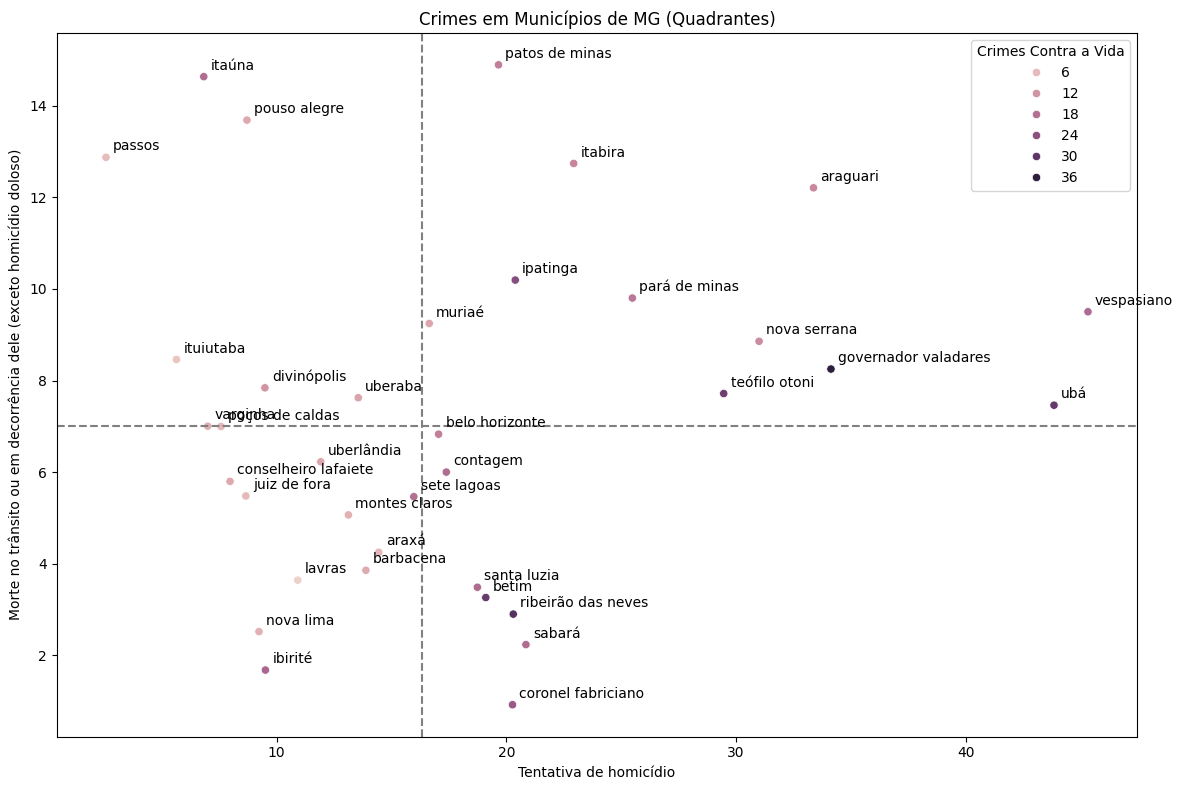

,Tentativa de homicídio,Morte no trânsito ou em decorrência dele (exceto homicídio doloso),Crimes Contra a Vida
municipio,,,
passos,2.574444,12.872222,6.007037
ituiutaba,5.639257,8.458885,4.699381
itaúna,6.829268,14.634146,18.536585
varginha,7.002703,7.002703,7.702973
poços de caldas,7.578717,6.995738,6.412760
conselheiro lafaiete,7.972170,5.797942,8.696913
juiz de fora,8.660855,5.479316,6.363077
pouso alegre,8.709122,13.685762,8.709122
nova lima,9.232680,2.518004,7.554011


In [6]:
analisar_seguranca_por_uf('MG',caminhos)

Analisando dados da UF: PR
Total de registros: 350112
Registros com município informado: 344736
Municípios com população > 100000 habitantes: 24

Sumário por categoria de crime:
categoria
Ocorrências não violentas                                             279403.0
Mortes a esclarecer (sem indício de crime)                             19123.0
Crimes Contra a Vida                                                   16178.0
Tentativa de homicídio                                                  8675.0
Morte no trânsito ou em decorrência dele (exceto homicídio doloso)      8518.0
Name: valor, dtype: float64

Ranking de municípios por taxa de tentativa de homicídio:
                      Tentativa de homicídio  \
municipio                                      
maringá                             2.112760   
londrina                            2.251792   
sarandi                             3.180029   
almirante tamandaré                 3.205436   
apucarana                           3.7228

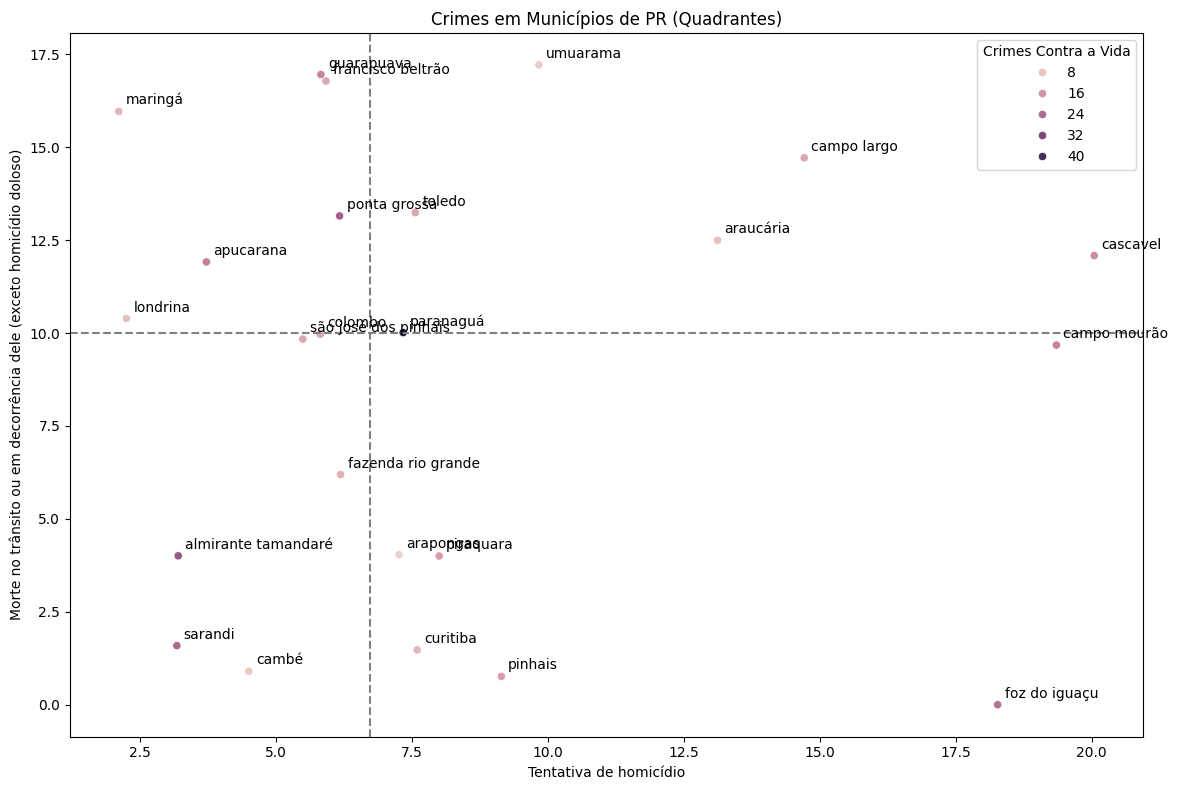

,Tentativa de homicídio,Morte no trânsito ou em decorrência dele (exceto homicídio doloso),Crimes Contra a Vida
municipio,,,
maringá,2.112760,15.963078,10.563802
londrina,2.251792,10.392886,8.487523
sarandi,3.180029,1.590015,24.645228
almirante tamandaré,3.205436,4.006796,28.047569
apucarana,3.722842,11.913094,20.103346
cambé,4.504139,0.900828,7.206623
são josé dos pinhais,5.496985,9.836711,12.729861
colombo,5.815886,9.970090,12.878033
guarapuava,5.829050,16.957236,19.076890


In [7]:
analisar_seguranca_por_uf('PR',caminhos)

Analisando dados da UF: SC
Total de registros: 325320
Registros com município informado: 318600
Municípios com população > 100000 habitantes: 14

Sumário por categoria de crime:
categoria
Ocorrências não violentas                                             93617.0
Tentativa de homicídio                                                15183.0
Crimes Contra a Vida                                                   7745.0
Morte no trânsito ou em decorrência dele (exceto homicídio doloso)     6935.0
Mortes a esclarecer (sem indício de crime)                               39.0
Name: valor, dtype: float64

Ranking de municípios por taxa de tentativa de homicídio:
                    Tentativa de homicídio  \
municipio                                    
jaraguá do sul                    7.662718   
criciúma                         11.985032   
tubarão                          12.121737   
brusque                          12.504195   
joinville                        12.521225   
blumenau     

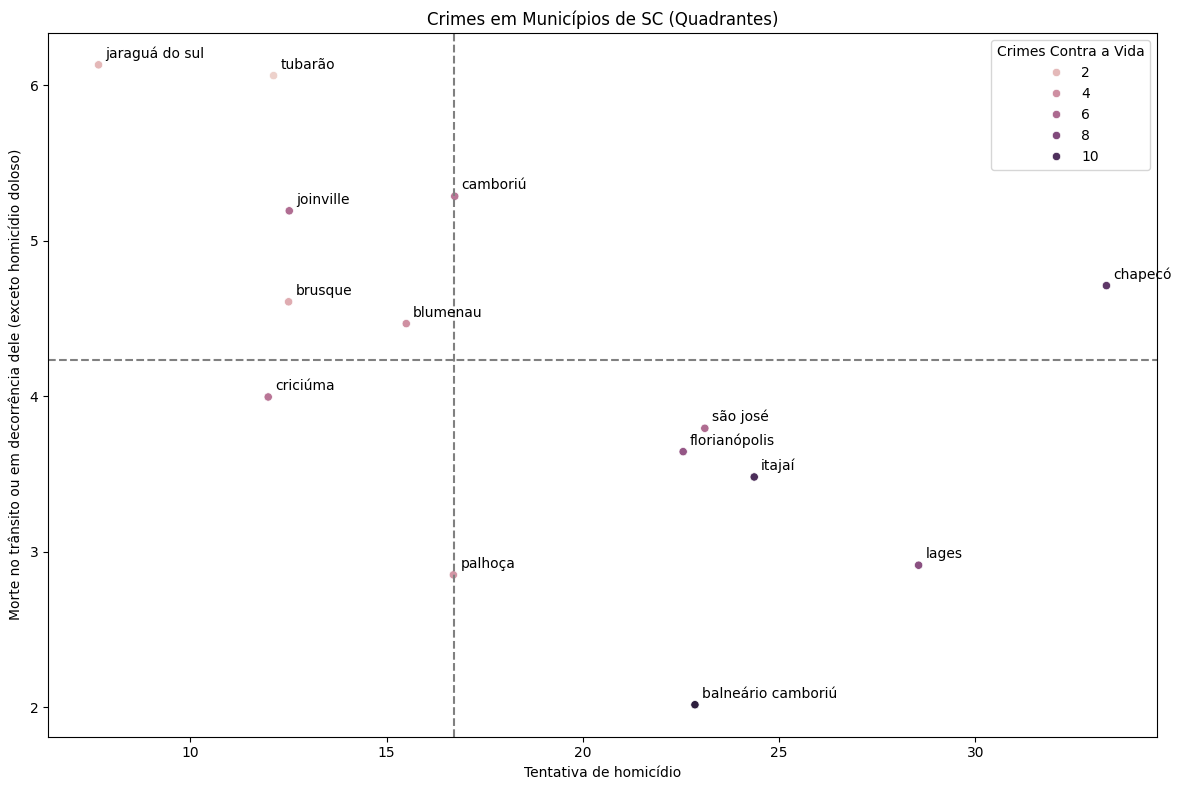

,Tentativa de homicídio,Morte no trânsito ou em decorrência dele (exceto homicídio doloso),Crimes Contra a Vida
municipio,,,
jaraguá do sul,7.662718,6.130174,2.043391
criciúma,11.985032,3.995011,5.326681
tubarão,12.121737,6.060868,0.865838
brusque,12.504195,4.606809,2.632462
joinville,12.521225,5.191727,5.802519
blumenau,15.501961,4.466667,3.941177
palhoça,16.702176,2.851591,3.666331
camboriú,16.736402,5.285179,5.285179
florianópolis,22.555308,3.643550,7.113597


In [8]:
analisar_seguranca_por_uf('SC',caminhos)

Analisando dados da UF: RS
Total de registros: 530976
Registros com município informado: 524832
Municípios com população > 100000 habitantes: 19

Sumário por categoria de crime:
categoria
Ocorrências não violentas                                             68382.0
Tentativa de homicídio                                                33397.0
Crimes Contra a Vida                                                  23187.0
Morte no trânsito ou em decorrência dele (exceto homicídio doloso)    12602.0
Mortes a esclarecer (sem indício de crime)                             6345.0
Name: valor, dtype: float64

Ranking de municípios por taxa de tentativa de homicídio:
                   Tentativa de homicídio  \
municipio                                   
santa cruz do sul                8.689104   
são leopoldo                    10.191918   
pelotas                         11.900122   
cachoeirinha                    12.030884   
novo hamburgo                   14.414170   
bagé                

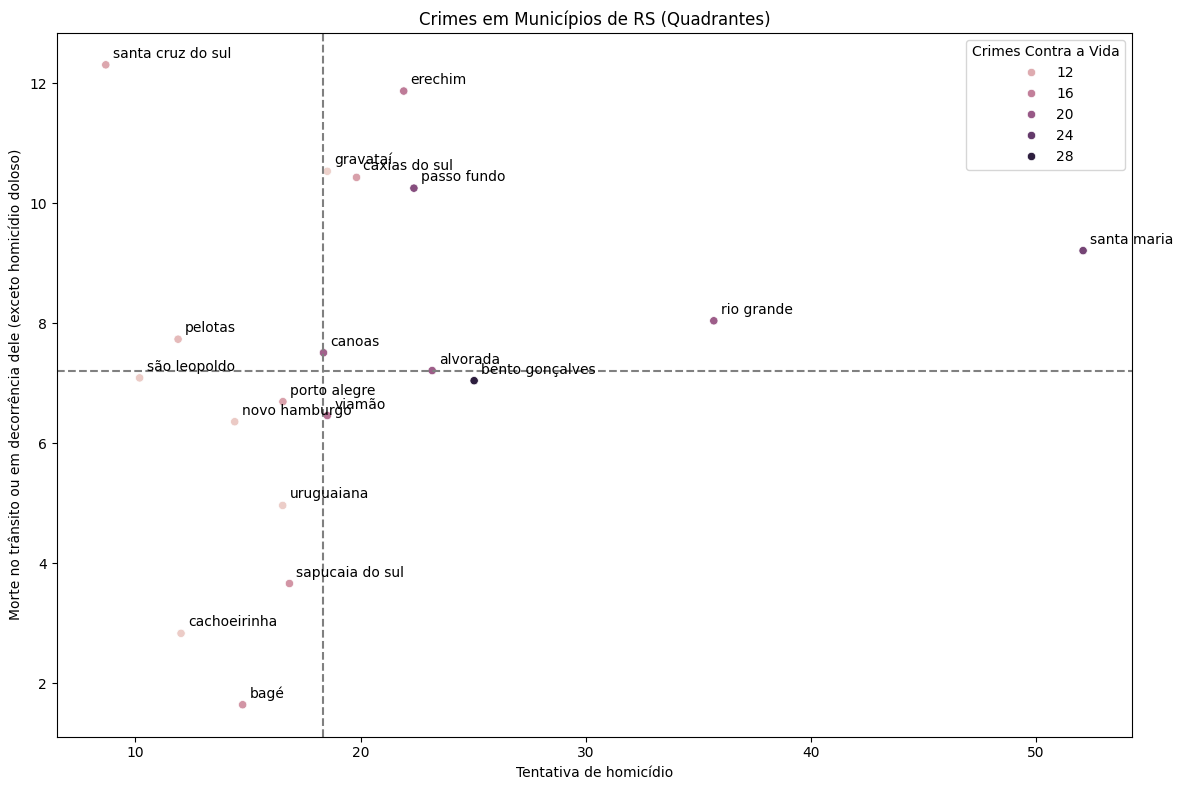

,Tentativa de homicídio,Morte no trânsito ou em decorrência dele (exceto homicídio doloso),Crimes Contra a Vida
municipio,,,
santa cruz do sul,8.689104,12.309564,12.309564
são leopoldo,10.191918,7.090030,9.305664
pelotas,11.900122,7.735079,10.710110
cachoeirinha,12.030884,2.830796,9.200088
novo hamburgo,14.414170,6.359193,9.326816
bagé,14.766202,1.640689,13.945857
uruguaiana,16.544650,4.963395,9.099557
porto alegre,16.554838,6.693913,12.883982
sapucaia do sul,16.844634,3.661877,13.915132


In [9]:
analisar_seguranca_por_uf('RS',caminhos)

Analisando dados da UF: CE
Total de registros: 205440
Registros com município informado: 198720
Municípios com população > 100000 habitantes: 9

Sumário por categoria de crime:
categoria
Crimes Contra a Vida                                                  35884.0
Ocorrências não violentas                                             30707.0
Morte no trânsito ou em decorrência dele (exceto homicídio doloso)    18398.0
Tentativa de homicídio                                                12023.0
Mortes a esclarecer (sem indício de crime)                             6772.0
Name: valor, dtype: float64

Ranking de municípios por taxa de tentativa de homicídio:
                   Tentativa de homicídio  \
municipio                                   
fortaleza                        7.574545   
itapipoca                        7.977258   
caucaia                          9.049051   
maranguape                      11.015541   
maracanaú                       14.818731   
juazeiro do norte    

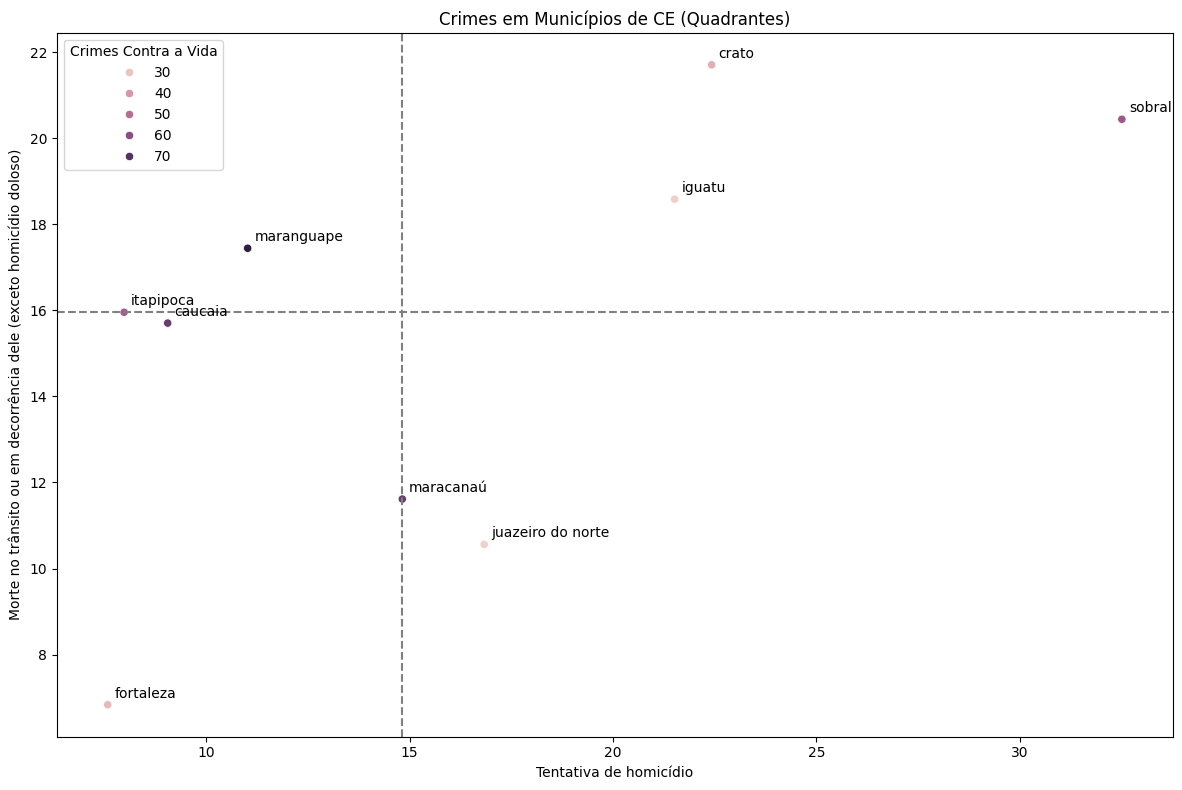

,Tentativa de homicídio,Morte no trânsito ou em decorrência dele (exceto homicídio doloso),Crimes Contra a Vida
municipio,,,
fortaleza,7.574545,6.836513,32.395747
itapipoca,7.977258,15.954515,55.115598
caucaia,9.049051,15.702765,66.270992
maranguape,11.015541,17.441273,78.026749
maracanaú,14.818731,11.614681,66.484036
juazeiro do norte,16.831461,10.560917,27.062349
iguatu,21.515682,18.581725,27.383595
crato,22.426066,21.702645,34.724232
sobral,32.514887,20.437929,56.204305


In [10]:
analisar_seguranca_por_uf('CE',caminhos)

Analisando dados da UF: PB
Total de registros: 247252
Registros com município informado: 240617
Municípios com população > 100000 habitantes: 4

Sumário por categoria de crime:
categoria
Ocorrências não violentas                                             17944.0
Crimes Contra a Vida                                                  11390.0
Tentativa de homicídio                                                10182.0
Morte no trânsito ou em decorrência dele (exceto homicídio doloso)     7955.0
Mortes a esclarecer (sem indício de crime)                                0.0
Name: valor, dtype: float64

Ranking de municípios por taxa de tentativa de homicídio:
                Tentativa de homicídio  \
municipio                                
campina grande                9.298338   
joão pessoa                  24.868372   
patos                        32.475365   
santa rita                   33.307986   

                Morte no trânsito ou em decorrência dele (exceto homicídio doloso) 

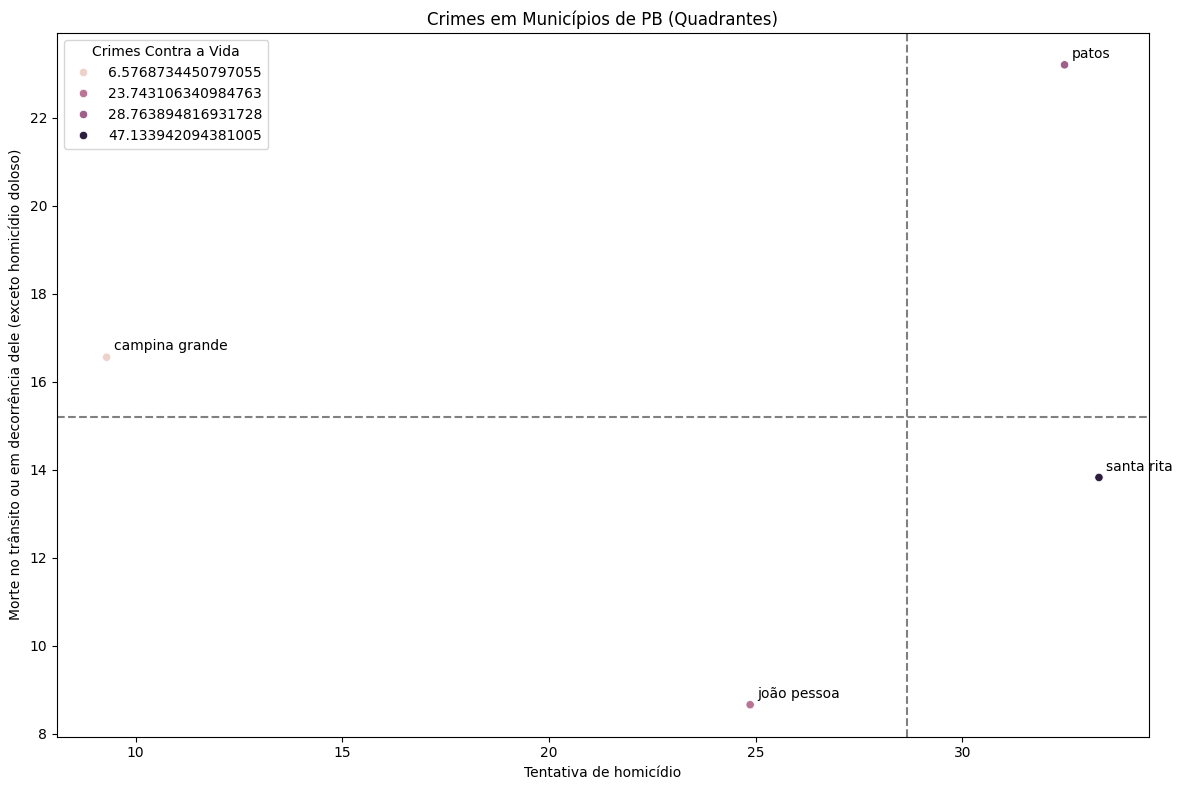

,Tentativa de homicídio,Morte no trânsito ou em decorrência dele (exceto homicídio doloso),Crimes Contra a Vida
municipio,,,
campina grande,9.298338,16.555578,6.576873
joão pessoa,24.868372,8.664546,23.743106
patos,32.475365,23.196689,28.763895
santa rita,33.307986,13.825956,47.133942


In [11]:
analisar_seguranca_por_uf('PB',caminhos)